In [1]:
import argparse
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!pip install faiss-cpu
!pip install -U sentence-transformers
import numpy as np
#import torch
import os
import pandas as pd
import faiss
import time
from sentence_transformers import SentenceTransformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyli

In [3]:
class BasicUnit(nn.Module):
    def __init__(self, channels: int, dropout: float):
        super(BasicUnit, self).__init__()
        self.block = nn.Sequential(OrderedDict([
            ("0_normalization", nn.BatchNorm2d(channels)),
            ("1_activation", nn.ReLU(inplace=True)),
            ("2_convolution", nn.Conv2d(channels, channels, (3, 3), stride=1, padding=1, bias=False)),
            ("3_normalization", nn.BatchNorm2d(channels)),
            ("4_activation", nn.ReLU(inplace=True)),
            ("5_dropout", nn.Dropout(dropout, inplace=True)),
            ("6_convolution", nn.Conv2d(channels, channels, (3, 3), stride=1, padding=1, bias=False)),
        ]))

    def forward(self, x):
        return x + self.block(x)


class DownsampleUnit(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, dropout: float):
        super(DownsampleUnit, self).__init__()
        self.norm_act = nn.Sequential(OrderedDict([
            ("0_normalization", nn.BatchNorm2d(in_channels)),
            ("1_activation", nn.ReLU(inplace=True)),
        ]))
        self.block = nn.Sequential(OrderedDict([
            ("0_convolution", nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=1, bias=False)),
            ("1_normalization", nn.BatchNorm2d(out_channels)),
            ("2_activation", nn.ReLU(inplace=True)),
            ("3_dropout", nn.Dropout(dropout, inplace=True)),
            ("4_convolution", nn.Conv2d(out_channels, out_channels, (3, 3), stride=1, padding=1, bias=False)),
        ]))
        #self.downsample = nn.Conv2d(in_channels, out_channels, (1, 1), stride=stride, padding=0, bias=False)
        self.downsample = nn.Conv2d(in_channels, out_channels, (1, 1), stride=stride, padding=0, bias=False)

    def forward(self, x):
        #x = self.norm_act(x)
        # Added a residual connection to preserve information
        residual = self.downsample(x)  # Apply downsampling directly to the input
        x = self.block(x)
        #return self.block(x) + self.downsample(x)
        return x + residual


class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, depth: int, dropout: float):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            DownsampleUnit(in_channels, out_channels, stride, dropout),
            *(BasicUnit(out_channels, dropout) for _ in range(depth))
        )

    def forward(self, x):
        return self.block(x)


class WideResNet(nn.Module):
    def __init__(self, depth: int, width_factor: int, dropout: float, in_channels: int, labels: int):
        super(WideResNet, self).__init__()

        self.filters = [16, 1 * 16 * width_factor, 2 * 16 * width_factor, 4 * 16 * width_factor]
        self.block_depth = (depth - 4) // (3 * 2)

        self.f = nn.Sequential(OrderedDict([
            ("0_convolution", nn.Conv2d(in_channels, self.filters[0], (3, 3), stride=1, padding=1, bias=False)),
            ("1_block", Block(self.filters[0], self.filters[1], 1, self.block_depth, dropout)),
            ("2_block", Block(self.filters[1], self.filters[2], 2, self.block_depth, dropout)),
            ("3_block", Block(self.filters[2], self.filters[3], 2, self.block_depth, dropout)),
            ("4_normalization", nn.BatchNorm2d(self.filters[3])),
            ("5_activation", nn.ReLU(inplace=True)),
            ("6_pooling", nn.AvgPool2d(kernel_size=8)),
            ("7_flattening", nn.Flatten()),
            ("8_classification", nn.Linear(in_features=self.filters[3], out_features=labels)),
        ]))

        self._initialize()

    def _initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode="fan_in", nonlinearity="relu")
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.zero_()
                m.bias.data.zero_()

    def forward(self, x):
        return self.f(x)

In [4]:
def smooth_crossentropy(pred, gold, smoothing=0.1):
    n_class = pred.size(1)

    one_hot = torch.full_like(pred, fill_value=smoothing / (n_class - 1))
    one_hot.scatter_(dim=1, index=gold.unsqueeze(1), value=1.0 - smoothing)
    log_prob = F.log_softmax(pred, dim=1)

    return F.kl_div(input=log_prob, target=one_hot, reduction='none').sum(-1)

In [5]:
#import torch


class Cutout:
    def __init__(self, size=16, p=0.5):
        self.size = size
        self.half_size = size // 2
        self.p = p

    def __call__(self, image):
        if torch.rand([1]).item() > self.p:
            return image

        left = torch.randint(-self.half_size, image.size(1) - self.half_size, [1]).item()
        top = torch.randint(-self.half_size, image.size(2) - self.half_size, [1]).item()
        right = min(image.size(1), left + self.size)
        bottom = min(image.size(2), top + self.size)

        image[:, max(0, left): right, max(0, top): bottom] = 0
        return image

In [7]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#from utility.cutout import Cutout

class Cifar:
    def __init__(self, batch_size, threads):
        mean, std = self._get_statistics()

        train_transform = transforms.Compose([
            #torchvision.transforms.RandomCrop(size=(32,32), padding=4),
            torchvision.transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            #transforms.Resize((32, 32))

        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

        self.train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=threads)
        self.test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=threads)

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    def _get_statistics(self):
        train_set = torchvision.datasets.CIFAR10(root='./cifar', train=True, download=True, transform=transforms.ToTensor())

        data = torch.cat([d[0] for d in DataLoader(train_set)])


        return data.mean(dim=[0, 2, 3]), data.std(dim=[0, 2, 3])

train_dataset = Cifar(batch_size=64, threads=4)

# Print the size of one sample in the training dataset
sample_image, _ = next(iter(train_dataset.train))
print("Original size of images in CIFAR dataset without resizing:", sample_image.size())

Files already downloaded and verified


100%|██████████| 170498071/170498071 [00:01<00:00, 102720298.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Original size of images in CIFAR dataset without resizing: torch.Size([64, 3, 32, 32])


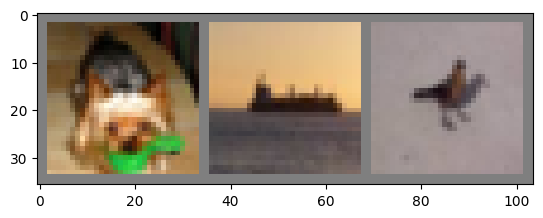

  dog  ship  bird


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get some random training images
data_iter = iter(train_dataset.train)
images, labels = next(data_iter)

# Define function to unnormalize and display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images[0:3]))
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(3)))


In [9]:
class LoadingBar:
    def __init__(self, length: int = 40):
        self.length = length
        self.symbols = ['┈', '░', '▒', '▓']

    def __call__(self, progress: float) -> str:
        p = int(progress * self.length*4 + 0.5)
        d, r = p // 4, p % 4
        return '┠┈' + d * '█' + ((self.symbols[r]) + max(0, self.length-1-d) * '┈' if p < self.length*4 else '') + "┈┨"

In [10]:
#from utility.loading_bar import LoadingBar
import time


class Log:
    def __init__(self, log_each: int, initial_epoch=-1, best_hyperparameters = None):
        self.loading_bar = LoadingBar(length=27)
        self.best_accuracy = 0.0
        self.log_each = log_each
        self.epoch = initial_epoch
        self.best_hyperparameters = best_hyperparameters

    def train(self, len_dataset: int) -> None:
        self.epoch += 1
        if self.epoch == 0:
            self._print_header()
        else:
            self.flush()

        self.is_train = True
        self.last_steps_state = {"loss": 0.0, "accuracy": 0.0, "steps": 0}
        self._reset(len_dataset)

    def eval(self, len_dataset: int) -> None:
        self.flush()
        self.is_train = False
        self._reset(len_dataset)

    def __call__(self, model, loss, accuracy, learning_rate: float = None) -> None:
        if self.is_train:
            self._train_step(model, loss, accuracy, learning_rate)
        else:
            self._eval_step(loss, accuracy)

    def flush(self) -> None:
        if self.is_train:
            loss = self.epoch_state["loss"] / self.epoch_state["steps"]
            accuracy = self.epoch_state["accuracy"] / self.epoch_state["steps"]

            print(
                f"\r┃{self.epoch:12d}  ┃{loss:12.4f}  │{100*accuracy:10.2f} %  ┃{self.learning_rate:12.3e}  │{self._time():>12}  ┃",
                end="",
                flush=True,
            )

        else:
            loss = self.epoch_state["loss"] / self.epoch_state["steps"]
            accuracy = self.epoch_state["accuracy"] / self.epoch_state["steps"]

            print(f"{loss:12.4f}  │{100*accuracy:10.2f} %  ┃", flush=True)

            if accuracy > self.best_accuracy:
                self.best_accuracy = accuracy
                self.best_hyperparameters = {
                "learning_rate": self.learning_rate,

                # Add other hyperparameters as needed
            }


    def _train_step(self, model, loss, accuracy, learning_rate: float) -> None:
        self.learning_rate = learning_rate
        self.last_steps_state["loss"] += loss.sum().item()
        self.last_steps_state["accuracy"] += accuracy.sum().item()
        self.last_steps_state["steps"] += loss.size(0)
        self.epoch_state["loss"] += loss.sum().item()
        self.epoch_state["accuracy"] += accuracy.sum().item()
        self.epoch_state["steps"] += loss.size(0)
        self.step += 1

        if self.step % self.log_each == self.log_each - 1:
            loss = self.last_steps_state["loss"] / self.last_steps_state["steps"]
            accuracy = self.last_steps_state["accuracy"] / self.last_steps_state["steps"]

            self.last_steps_state = {"loss": 0.0, "accuracy": 0.0, "steps": 0}
            progress = self.step / self.len_dataset

            print(
                f"\r┃{self.epoch:12d}  ┃{loss:12.4f}  │{100*accuracy:10.2f} %  ┃{learning_rate:12.3e}  │{self._time():>12}  {self.loading_bar(progress)}",
                end="",
                flush=True,
            )

    def _eval_step(self, loss, accuracy) -> None:
        self.epoch_state["loss"] += loss.sum().item()
        self.epoch_state["accuracy"] += accuracy.sum().item()
        self.epoch_state["steps"] += loss.size(0)

    def _reset(self, len_dataset: int) -> None:
        self.start_time = time.time()
        self.step = 0
        self.len_dataset = len_dataset
        self.epoch_state = {"loss": 0.0, "accuracy": 0.0, "steps": 0}

    def _time(self) -> str:
        time_seconds = int(time.time() - self.start_time)
        return f"{time_seconds // 60:02d}:{time_seconds % 60:02d} min"



    def _print_header(self) -> None:
        print(f"┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓")
        print(f"┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃")
        print(f"┃       epoch  ┃        loss  │    accuracy  ┃        l.r.  │     elapsed  ┃        loss  │    accuracy  ┃")
        print(f"┠──────────────╂──────────────┼──────────────╂──────────────┼──────────────╂──────────────┼──────────────┨")

In [11]:
import random

def initialize(args, seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False

In [12]:
class StepLR:
    def __init__(self, optimizer, learning_rate: float, total_epochs: int):
        self.optimizer = optimizer
        self.total_epochs = total_epochs
        self.base = learning_rate

    def __call__(self, epoch):
        if epoch < self.total_epochs * 3/10:
            lr = self.base
        elif epoch < self.total_epochs * 6/10:
            lr = self.base * 0.2
        elif epoch < self.total_epochs * 8/10:
            lr = self.base * 0.2 ** 2
        else:
            lr = self.base * 0.2 ** 3

        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def lr(self) -> float:
        return self.optimizer.param_groups[0]["lr"]

In [13]:
import math

class CosineAnnealingLR:
    def __init__(self, optimizer, initial_lr: float, total_epochs: int):
        self.optimizer = optimizer
        self.total_epochs = total_epochs
        self.initial_lr = initial_lr

    def __call__(self, epoch):
        lr = self.initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / self.total_epochs))

        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def lr(self) -> float:
        return self.optimizer.param_groups[0]["lr"]


In [14]:

from torch.nn.modules.batchnorm import _BatchNorm


def disable_running_stats(model):
    def _disable(module):
        if isinstance(module, _BatchNorm):
            module.backup_momentum = module.momentum
            module.momentum = 0

    model.apply(_disable)

def enable_running_stats(model):
    def _enable(module):
        if isinstance(module, _BatchNorm) and hasattr(module, "backup_momentum"):
            module.momentum = module.backup_momentum

    model.apply(_enable)

In [15]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [16]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.4 MB/s eta 0:00:00


In [17]:
def extract_features(model, dataloader, device):
    all_features = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = (b.to(device) for b in batch)
            features = model(inputs)  # Assuming a method 'extract_features' in your model
            all_features.append(features.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_features = np.concatenate(all_features)
    all_targets = np.concatenate(all_targets)

    return all_features, all_targets

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓
┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃
┃       epoch  ┃        loss  │    accuracy  ┃        l.r.  │     elapsed  ┃        loss  │    accuracy  ┃
┠──────────────╂──────────────┼──────────────╂──────────────┼──────────────╂──────────────┼──────────────┨


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


┃           0  ┃      0.9804  │     53.98 %  ┃   1.000e-01  │   03:26 min  ┠┈██████████████████████████▓┈┨

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


┃           0  ┃      1.2588  │     39.28 %  ┃   1.000e-01  │   03:27 min  ┃      1.7896  │     28.83 %  ┃
┃           1  ┃      0.8681  │     60.03 %  ┃   9.938e-02  │   03:35 min  ┃      1.2955  │     42.03 %  ┃
┃           2  ┃      0.6753  │     69.87 %  ┃   9.755e-02  │   03:37 min  ┃      1.1803  │     49.10 %  ┃
┃           3  ┃      0.5400  │     76.66 %  ┃   9.455e-02  │   03:37 min  ┃      0.7559  │     67.73 %  ┃
┃           4  ┃      0.4411  │     81.64 %  ┃   9.045e-02  │   03:37 min  ┃      0.6276  │     73.23 %  ┃
┃           5  ┃      0.3760  │     84.56 %  ┃   8.536e-02  │   03:40 min  ┃      0.7638  │     66.24 %  ┃
┃           6  ┃      0.3298  │     86.61 %  ┃   7.939e-02  │   03:43 min  ┃      0.6586  │     71.36 %  ┃
┃           7  ┃      0.2854  │     88.47 %  ┃   7.270e-02  │   03:44 min  ┃      0.5549  │     75.99 %  ┃
┃           8  ┃      0.2507  │     90.08 %  ┃   6.545e-02  │   03:44 min  ┃      0.6137  │     73.23 %  ┃
┃           9  ┃      0.2196  │     9

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


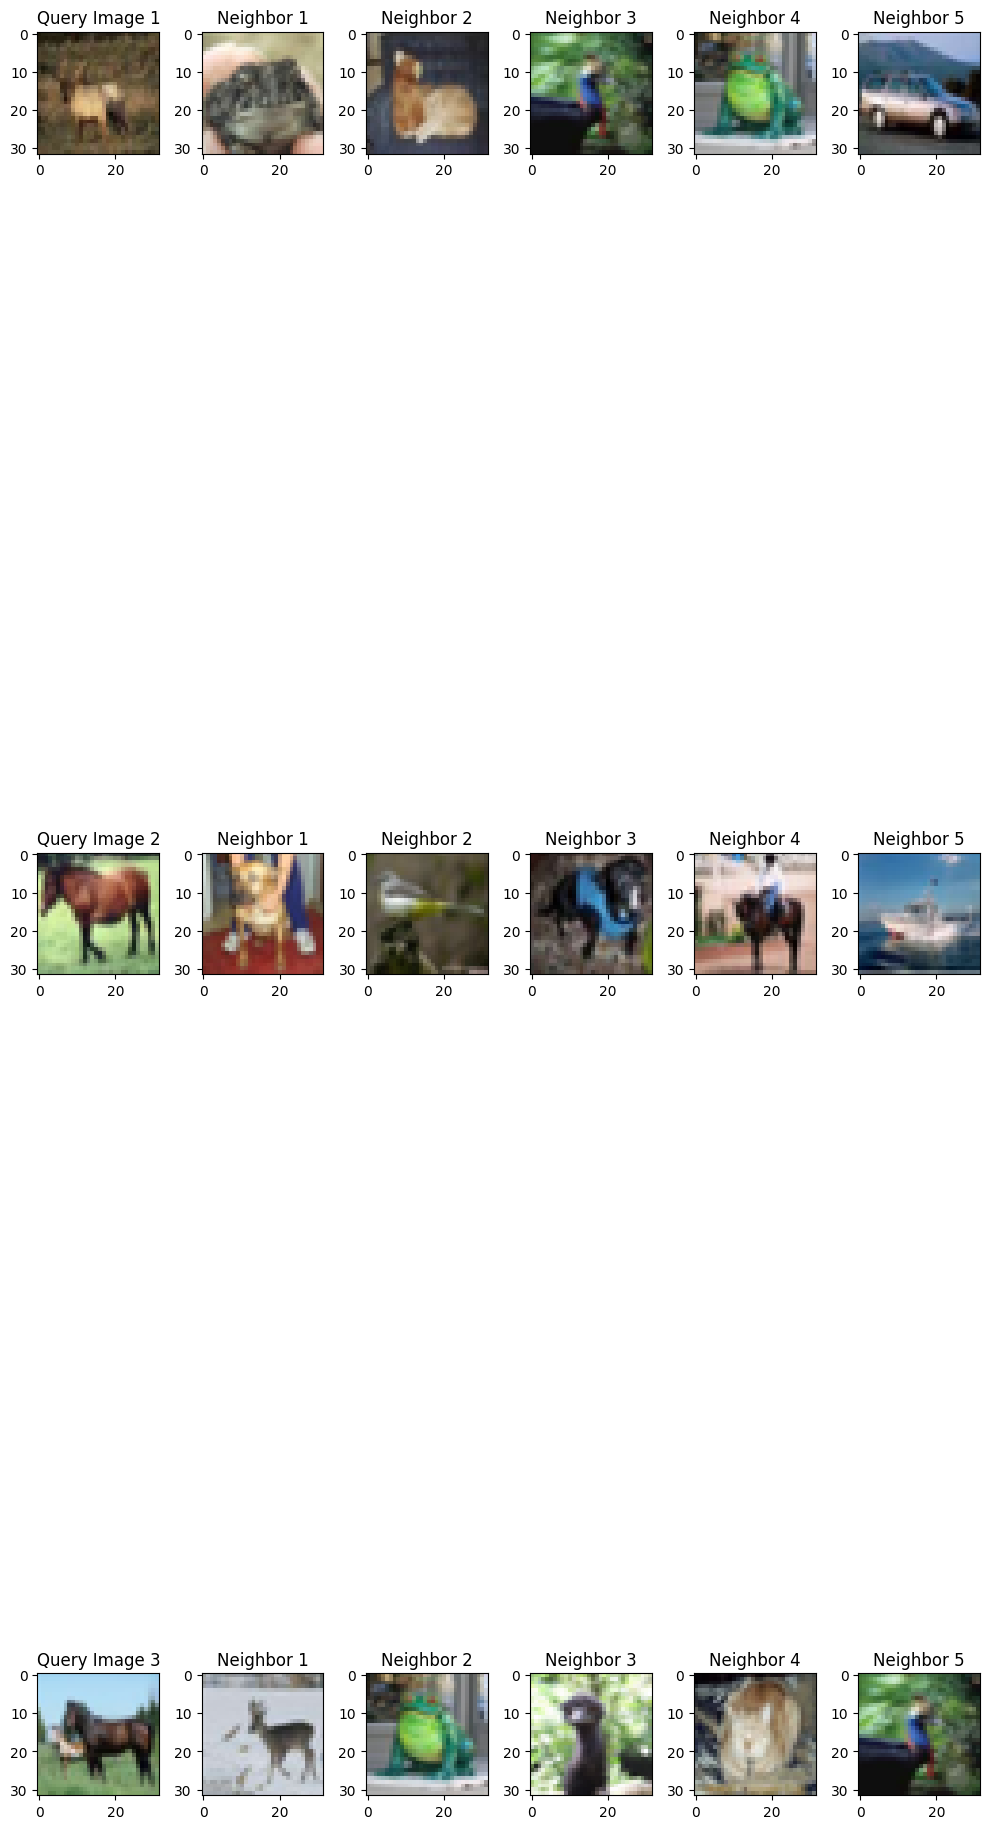

In [21]:
import sys; sys.path.append("..")
#from sam import SAM
import itertools

import matplotlib.pyplot as plt
from PIL import Image

# Define hyperparameters and their possible values
hyperparameters = {
    'learning_rate': [0.001],
    'batch_size': [64],
    'dropout': [0.0],
    # Add more hyperparameters as needed
}

# Perform grid search



if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--adaptive", default=True, type=bool, help="True if you want to use the Adaptive SAM.")
    parser.add_argument("--batch_size", default=128, type=int, help="Batch size used in the training and validation loop.")
    parser.add_argument("--depth", default=16, type=int, help="Number of layers.")
    parser.add_argument("--dropout", default=0.0, type=float, help="Dropout rate.")
    parser.add_argument("--epochs", default=20, type=int, help="Total number of epochs.")
    parser.add_argument("--label_smoothing", default=0.1, type=float, help="Use 0.0 for no label smoothing.")
    parser.add_argument("--learning_rate", default=0.1, type=float, help="Base learning rate at the start of the training.")
    parser.add_argument("--momentum", default=0.9, type=float, help="SGD Momentum.")
    parser.add_argument("--threads", default=2, type=int, help="Number of CPU threads for dataloaders.")
    parser.add_argument("--rho", default=2.0, type=int, help="Rho parameter for SAM.")
    parser.add_argument("--weight_decay", default=0.0005, type=float, help="L2 weight decay.")
    parser.add_argument("--width_factor", default=8, type=int, help="How many times wider compared to normal ResNet.")

    args = argparse.Namespace(
        adaptive=True,
        batch_size=128,
        depth=16,
        dropout=0.0,
        epochs=20,
        label_smoothing=0.1,
        learning_rate=0.1,
        momentum=0.9,
        threads=2,
        rho=2.0,
        weight_decay=0.0005,
        width_factor=8
    )


    #args = parser.parse_args()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    dataset = Cifar(args.batch_size, args.threads)
    initialize(args, seed=42)
    log = Log(log_each=10)
    model = WideResNet(args.depth, args.width_factor, args.dropout, in_channels=3, labels=10).to(device)

    base_optimizer = torch.optim.SGD
    optimizer = SAM(model.parameters(), base_optimizer, rho=args.rho, adaptive=args.adaptive, lr=args.learning_rate, momentum=args.momentum, weight_decay=args.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, args.learning_rate, args.epochs)
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


    for epoch in range(args.epochs):
       model.train()
       log.train(len_dataset=len(dataset.train))

       for batch in dataset.train:
         inputs, targets = (b.to(device) for b in batch)

         # first forward-backward step
         enable_running_stats(model)
         predictions = model(inputs)
         loss = smooth_crossentropy(predictions, targets, smoothing=args.label_smoothing)
         loss.mean().backward()
         optimizer.first_step(zero_grad=True)

         # second forward-backward step
         disable_running_stats(model)
         smooth_crossentropy(model(inputs), targets, smoothing=args.label_smoothing).mean().backward()
         optimizer.second_step(zero_grad=True)

         with torch.no_grad():
            correct = torch.argmax(predictions.data, 1) == targets
            log(model, loss.cpu(), correct.cpu(), scheduler.lr())
            #log(model, loss.cpu(), correct.cpu(), scheduler._reduce_lr(epoch))
            scheduler(epoch)
            #scheduler.step(loss.mean().item(), epoch)


       model.eval()
       log.eval(len_dataset=len(dataset.test))

       with torch.no_grad():
          for batch in dataset.test:
            inputs, targets = (b.to(device) for b in batch)

            predictions = model(inputs)
            loss = smooth_crossentropy(predictions, targets)
            correct = torch.argmax(predictions, 1) == targets
            log(model, loss.cpu(), correct.cpu())




    log.flush()

    train_transform = transforms.Compose([
            #torchvision.transforms.RandomCrop(size=(1080,1080), padding=8),
            #transforms.Resize((1080, 1080)),
            torchvision.transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)


    # Get the training data

    traindata = next(iter(train_dataset.train))

    traindata = traindata[0].view(traindata[0].shape[0], -1)

   ##### INdexing using FlatL2 Index
    # Initialize the Faiss index

    d = traindata.shape[1]

    index = faiss.IndexFlatL2(d)


    # Add the training data to the index

    index.add(traindata.numpy())



     # Save the index

    faiss.write_index(index, 'cifar10_index.faiss')
    # Load the index
    index = faiss.read_index('cifar10_index.faiss')

    # Get the query images and their indices
    query_indices = [3, 7, 12]  # Modify this list with indices of your query images
    query_images = [traindata[i].numpy() for i in query_indices]

    # Find the nearest neighbors for each query image
    k = 5
    nearest_neighbors_indices = []
    for query_image in query_images:
       D, I = index.search(np.array([query_image]), k + 1)  # Add 1 to k to exclude the query image itself
       nearest_neighbors_indices.append(I[0][1:])  # Exclude the first nearest neighbor which is the query image itself

    # Display the query images and their nearest neighbors
    num_queries = len(query_images)
    plt.figure(figsize=(10, 10 * num_queries))

    for i, query_index in enumerate(query_indices):
      plt.subplot(num_queries, k + 1, i * (k + 1) + 1)
      plt.imshow(train_set.data[query_index])
      plt.title(f'Query Image {i + 1}')

      for j, neighbor_index in enumerate(nearest_neighbors_indices[i]):
         plt.subplot(num_queries, k + 1, i * (k + 1) + j + 2)
         plt.imshow(train_set.data[neighbor_index])
         plt.title(f'Neighbor {j + 1}')

    plt.tight_layout()
    plt.show()






In [ ]:
#### This is indexing Using  IVFF (Inverted File with Flat Index) #######




train_transform = transforms.Compose([
            torchvision.transforms.RandomCrop(size=(32,32), padding=8),
            transforms.Resize((32, 32)),
            torchvision.transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)


    #train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)

traindata = next(iter(train_dataset.train))
traindata = traindata[0].view(traindata[0].shape[0], -1)

# Initialize the Faiss index
d = traindata.shape[1]
nlist = 20  # Number of clusters (centroids)
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

# Add the training data to the index
index.train(traindata.numpy())  # Assuming traindata is a numpy array
index.add(traindata.numpy())

# Save the index
faiss.write_index(index, 'cifar10_index.faiss')

# Load the index
index = faiss.read_index('cifar10_index.faiss')

# Get the query images and their indices
query_indices = [3, 7, 12]  # Modify this list with indices of your query images
query_images = [traindata[i] for i in query_indices]

# Find the nearest neighbors for each query image
k = 5
nearest_neighbors_indices = []
for query_image in query_images:
   D, I = index.search(np.array([query_image]), k)  # Add 1 to k to exclude the query image itself
   nearest_neighbors_indices.append(I[0][1:])  # Exclude the first nearest neighbor which is the query image itself

# Display the query images and their nearest neighbors
num_queries = len(query_images)
plt.figure(figsize=(10, 10 * num_queries))

for i, query_index in enumerate(query_indices):
   plt.subplot(num_queries, k + 1, i * (k + 1) + 1)
   plt.imshow(train_set.data[query_index])
   plt.title(f'Query Image {i + 1}')

   for j, neighbor_index in enumerate(nearest_neighbors_indices[i]):
      plt.subplot(num_queries, k + 1, i * (k + 1) + j + 2)
      plt.imshow(train_set.data[neighbor_index])
      plt.title(f'Neighbor {j + 1}')

plt.tight_layout()
plt.show()

In [22]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Select query images and their labels
#num_query_images = 10  # Adjust this number as needed
query_indices = [3,7,12]
query_images = torch.stack([cifar10_dataset[i][0] for i in query_indices])
query_labels = torch.tensor([cifar10_dataset[i][1] for i in query_indices])

# Find true nearest neighbors for each query image
ground_truths = []
for query_label in query_labels:
    nearest_neighbors = [i for i, (image, label) in enumerate(cifar10_dataset) if label == query_label]
    ground_truths.append(nearest_neighbors)

print("Ground Truths (Indices of Nearest Neighbors):")
print(ground_truths)


Files already downloaded and verified
Ground Truths (Indices of Nearest Neighbors):
[[3, 10, 20, 28, 34, 58, 66, 82, 86, 89, 98, 130, 145, 149, 153, 158, 162, 175, 180, 247, 254, 263, 268, 272, 296, 299, 310, 336, 343, 345, 346, 363, 372, 378, 381, 390, 398, 399, 414, 420, 429, 434, 435, 447, 449, 458, 477, 484, 489, 490, 505, 520, 521, 526, 528, 543, 549, 563, 572, 581, 616, 621, 622, 632, 642, 660, 661, 665, 669, 674, 677, 693, 705, 711, 712, 725, 758, 764, 780, 816, 831, 844, 856, 868, 876, 887, 904, 925, 930, 934, 939, 945, 946, 951, 959, 966, 976, 979, 982, 1001, 1004, 1005, 1007, 1018, 1022, 1069, 1143, 1148, 1158, 1169, 1182, 1203, 1212, 1221, 1225, 1238, 1254, 1256, 1264, 1268, 1269, 1284, 1294, 1297, 1299, 1303, 1310, 1311, 1312, 1313, 1315, 1324, 1333, 1339, 1347, 1348, 1349, 1350, 1366, 1373, 1385, 1387, 1388, 1396, 1406, 1407, 1425, 1435, 1450, 1451, 1457, 1471, 1491, 1509, 1516, 1526, 1535, 1557, 1569, 1575, 1595, 1615, 1623, 1624, 1630, 1639, 1640, 1644, 1654, 1657, 1659,

In [36]:
def calculate_precision_recall_at_k(ground_truths, nearest_neighbors_indices, k):
    precision_sum = 0
    recall_sum = 0
    total_queries = len(ground_truths)

    for i in range(total_queries):
        true_neighbors = set(ground_truths[i])
        retrieved_neighbors = set(nearest_neighbors_indices[i][:k])

        # Calculate precision@k
        precision = len(true_neighbors.intersection(retrieved_neighbors)) / k
        precision_sum += precision

        # Calculate recall@k
        recall = len(true_neighbors.intersection(retrieved_neighbors)) / len(true_neighbors)
        recall_sum += recall

    precision_at_k = precision_sum / total_queries
    recall_at_k = recall_sum / total_queries

    return precision_at_k, recall_at_k

# Example usage:
k = 5  # Define the value of k for precision@k and recall@k
precision_at_5, recall_at_5 = calculate_precision_recall_at_k(ground_truths, nearest_neighbors_indices, k)

print("Precision@{}: {:.4f}".format(k, precision_at_5))
print("Recall@{}: {:.4f}".format(k, recall_at_5))


Precision@5: 0.0667
Recall@5: 0.0001


In [28]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the class we're interested in (e.g., "airplane")
target_class = 0  # "airplane" class

# Calculate relevance scores for each image
relevance_scores = []
for image, label in cifar10_dataset:
    relevance_score = 1 if label == target_class else 0
    relevance_scores.append(relevance_score)

# Now relevance_scores contains the relevance score for each image in the dataset


Files already downloaded and verified


In [35]:
import numpy as np
# Assuming you have a CIFAR-10 dataset object called 'cifar10_dataset'
# Retrieve the labels from the dataset
labels = cifar10_dataset.targets

# Assign these labels to the class_labels variable
class_labels = labels


def get_relevance_scores_for_class(class_labels, target_class):
    """
    Get relevance scores for items based on their class labels.

    Args:
    - class_labels: List of class labels for the items
    - target_class: Class label of interest

    Returns:
    - List of relevance scores, where 1 indicates relevance to the target class and 0 otherwise
    """
    relevance_scores = [1 if label == target_class else 0 for label in class_labels]
    return relevance_scores

def dcg_at_k(scores, k):
    """
    Calculate the Discounted Cumulative Gain (DCG) at rank k.

    Args:
    - scores: Relevance scores for the retrieved items
    - k: Rank at which to calculate DCG

    Returns:
    - DCG at rank k
    """
    scores = np.asarray(scores)[:k]
    gain = 2 ** scores - 1
    discounts = np.log2(np.arange(len(scores)) + 2)
    return np.sum(gain / discounts)

def ndcg_at_k(scores, k):
    """
    Calculate the Normalized Discounted Cumulative Gain (NDCG) at rank k.

    Args:
    - scores: Relevance scores for the retrieved items
    - k: Rank at which to calculate NDCG

    Returns:
    - NDCG at rank k
    """
    dcg = dcg_at_k(scores, k)
    ideal_scores = sorted(scores, reverse=True)
    idcg = dcg_at_k(ideal_scores, k)
    return dcg / idcg if idcg != 0 else 0

# Assuming `class_labels` contains the class labels for each item and `traindata` contains the images
# `query_image_index` is the index of the query image in the dataset
query_image_index = 7
target_class = class_labels[query_image_index]
query_image_relevance_scores = get_relevance_scores_for_class(class_labels, target_class)

# Let's assume we retrieved the top-10 items and have their relevance scores in query_image_relevance_scores
top_k = 10
ndcg = ndcg_at_k(query_image_relevance_scores, top_k)
print("NDCG at rank {} for the class '{}': {:.4f}".format(top_k, target_class, ndcg))


NDCG at rank 10 for the class '7': 0.0694
